# Implementando una GAN

In [ ]:
#@title Importar librerías
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
#@title Funciones complementarias

def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(gen_losses, label='Pérdida del Generador', color='blue')
    plt.plot(disc_losses, label='Pérdida del Discriminador', color='red')
    plt.title('Pérdidas del Generador y Discriminador a lo largo del tiempo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()

Cargamos el dataset MNIST. Un paso crucial es normalizar las imágenes a un rango de [-1, 1], lo que mejora la estabilidad del entrenamiento.

In [ ]:
# Hiperparámetros
BUFFER_SIZE = 60000   # para optimizar el entrenamiento
BATCH_SIZE = 256
LATENT_DIM = 100 # Dimensión del vector de ruido
epochs = 100

# Cargar y preprocesar el dataset MNIST
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalizar a [-1, 1]

print(train_images.shape)

# Crear un tf.data.Dataset para un entrenamiento eficiente
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 28, 28, 1)


## Arquitectura de los Modelos

Definimos las redes del Generador y del Discriminador. Usamos capas convolucionales y de-convolucionales para procesar y generar las imágenes.

## Modelo del Generador

El generador toma un vector de ruido y lo convierte en una imagen, usando capas de Conv2DTranspose para aumentar la resolución.

In [ ]:
def build_generator(latent_dim):
    model = tf.keras.Sequential(name='Generator')
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    # Capa de de-convolución para aumentar la resolución a 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Sube la resolución a 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Salida final: imagen de 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Modelo del Discriminador

El discriminador es un clasificador que toma una imagen y predice si es real (cerca de 1) o falsa (cerca de 0).

In [ ]:
def build_discriminator(image_shape):
    model = tf.keras.Sequential(name='Discriminator')
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=image_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Salida como un único logit

    return model

# Fórmulas de Pérdida y su Implementación

El corazón de la GAN es su función de pérdida adversarial, que a menudo se representa como un juego minmax.

$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]$

## Pérdida del Discriminador
El discriminador busca maximizar la función V, lo que equivale a minimizar su propia pérdida, $L_D$. Esta pérdida se compone de dos términos: uno para los datos reales (etiqueta 1) y otro para los datos falsos (etiqueta 0).

$L_D = -\mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] - \mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]$

In [ ]:
# Usamos BinaryCrossentropy con from_logits=True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # L_real = -E[log D(x)]: pérdida para los datos reales (etiqueta 1)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # L_fake = -E[log(1 - D(G(z)))]: pérdida para los datos falsos (etiqueta 0)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # L_total = L_real + L_fake
    total_loss = real_loss + fake_loss
    return total_loss

## Pérdida del Generador
El generador busca minimizar la función V. Su objetivo es engañar al discriminador, por lo que su pérdida, $L_G$, se calcula comparando la predicción de las imágenes falsas con la etiqueta 1 ("real").

$L_G = - \mathbb{E}_{z \sim p_z(z)}[\log D(G(z))]$

In [ ]:
def generator_loss(fake_output):
    # El generador quiere que el discriminador clasifique las imágenes falsas como 1s
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizadores
Usamos optimizadores Adam separados para que cada red pueda actualizar sus pesos independientemente.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Bucle de Entrenamiento y Ejecución
El entrenamiento de una GAN se realiza en un ciclo de dos pasos: entrenar al discriminador, luego al generador. Usamos tf.function para optimizar el rendimiento.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Comenzando el entrenamiento...


  1%|          | 1/100 [00:20<34:08, 20.69s/it]

Época 1, Pérdida Generador: 0.7682, Pérdida Discriminador: 1.0427


  2%|▏         | 2/100 [00:41<33:35, 20.56s/it]

Época 2, Pérdida Generador: 0.8585, Pérdida Discriminador: 1.1998


  3%|▎         | 3/100 [00:51<25:57, 16.06s/it]

Época 3, Pérdida Generador: 1.3174, Pérdida Discriminador: 0.9072


  4%|▍         | 4/100 [01:12<28:28, 17.80s/it]

Época 4, Pérdida Generador: 0.8962, Pérdida Discriminador: 1.2319
Época 5, Pérdida Generador: 0.9154, Pérdida Discriminador: 1.2828


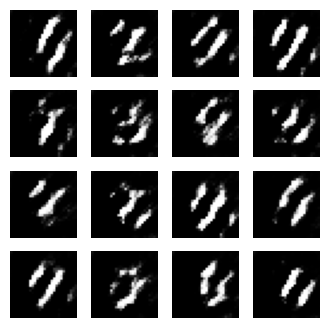

  6%|▌         | 6/100 [01:34<21:43, 13.87s/it]

Época 6, Pérdida Generador: 0.8549, Pérdida Discriminador: 1.2938


  7%|▋         | 7/100 [01:54<24:50, 16.03s/it]

Época 7, Pérdida Generador: 0.9241, Pérdida Discriminador: 1.2403


  8%|▊         | 8/100 [02:05<22:08, 14.44s/it]

Época 8, Pérdida Generador: 0.9121, Pérdida Discriminador: 1.2696


  9%|▉         | 9/100 [02:16<20:17, 13.38s/it]

Época 9, Pérdida Generador: 0.9511, Pérdida Discriminador: 1.1447
Época 10, Pérdida Generador: 0.9949, Pérdida Discriminador: 1.2076


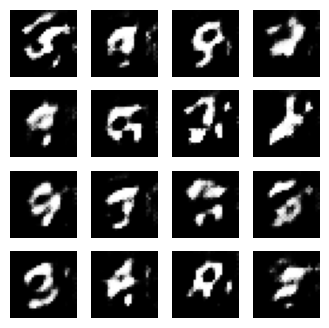

 11%|█         | 11/100 [02:39<18:09, 12.24s/it]

Época 11, Pérdida Generador: 0.9860, Pérdida Discriminador: 1.2167


 12%|█▏        | 12/100 [02:50<17:29, 11.93s/it]

Época 12, Pérdida Generador: 0.9554, Pérdida Discriminador: 1.1741


 13%|█▎        | 13/100 [03:01<17:00, 11.73s/it]

Época 13, Pérdida Generador: 0.9995, Pérdida Discriminador: 1.1283


 14%|█▍        | 14/100 [03:13<16:40, 11.64s/it]

Época 14, Pérdida Generador: 1.0476, Pérdida Discriminador: 1.1429
Época 15, Pérdida Generador: 1.1402, Pérdida Discriminador: 1.0614


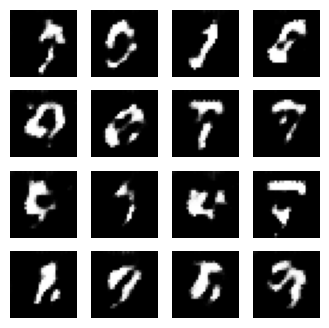

 16%|█▌        | 16/100 [03:36<16:14, 11.60s/it]

Época 16, Pérdida Generador: 1.0918, Pérdida Discriminador: 1.1061


 17%|█▋        | 17/100 [03:47<15:58, 11.55s/it]

Época 17, Pérdida Generador: 1.1592, Pérdida Discriminador: 1.0873


 18%|█▊        | 18/100 [03:59<15:43, 11.50s/it]

Época 18, Pérdida Generador: 1.1705, Pérdida Discriminador: 1.0983


 19%|█▉        | 19/100 [04:10<15:28, 11.46s/it]

Época 19, Pérdida Generador: 1.1818, Pérdida Discriminador: 1.0607
Época 20, Pérdida Generador: 1.2809, Pérdida Discriminador: 0.9924


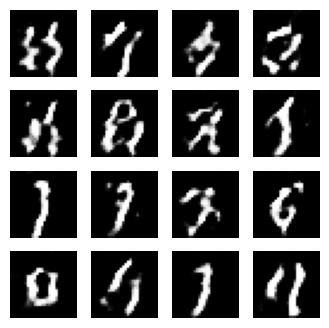

 21%|██        | 21/100 [04:42<17:38, 13.40s/it]

Época 21, Pérdida Generador: 1.2353, Pérdida Discriminador: 1.0174


 22%|██▏       | 22/100 [04:54<16:40, 12.83s/it]

Época 22, Pérdida Generador: 1.1974, Pérdida Discriminador: 1.0726


 23%|██▎       | 23/100 [05:05<15:59, 12.46s/it]

Época 23, Pérdida Generador: 1.2296, Pérdida Discriminador: 1.0790


 24%|██▍       | 24/100 [05:17<15:25, 12.17s/it]

Época 24, Pérdida Generador: 1.2837, Pérdida Discriminador: 1.0146
Época 25, Pérdida Generador: 1.2208, Pérdida Discriminador: 1.0640


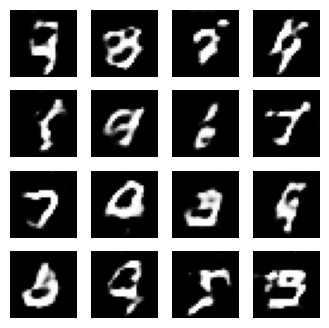

 26%|██▌       | 26/100 [05:40<14:39, 11.89s/it]

Época 26, Pérdida Generador: 1.1413, Pérdida Discriminador: 1.0985


 27%|██▋       | 27/100 [05:52<14:16, 11.73s/it]

Época 27, Pérdida Generador: 1.1096, Pérdida Discriminador: 1.1574


 28%|██▊       | 28/100 [06:12<17:13, 14.35s/it]

Época 28, Pérdida Generador: 1.1044, Pérdida Discriminador: 1.1458


 29%|██▉       | 29/100 [06:23<15:56, 13.48s/it]

Época 29, Pérdida Generador: 1.0831, Pérdida Discriminador: 1.1524
Época 30, Pérdida Generador: 1.0313, Pérdida Discriminador: 1.1856


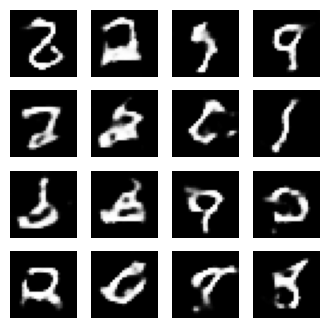

 31%|███       | 31/100 [06:47<14:26, 12.56s/it]

Época 31, Pérdida Generador: 1.0002, Pérdida Discriminador: 1.2063


 32%|███▏      | 32/100 [07:07<16:55, 14.93s/it]

Época 32, Pérdida Generador: 0.9955, Pérdida Discriminador: 1.2053


 33%|███▎      | 33/100 [07:28<18:31, 16.59s/it]

Época 33, Pérdida Generador: 0.9735, Pérdida Discriminador: 1.2122


 34%|███▍      | 34/100 [07:39<16:33, 15.05s/it]

Época 34, Pérdida Generador: 0.9659, Pérdida Discriminador: 1.2332
Época 35, Pérdida Generador: 1.0457, Pérdida Discriminador: 1.2136


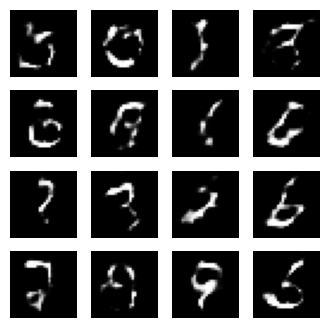

 36%|███▌      | 36/100 [08:03<14:13, 13.34s/it]

Época 36, Pérdida Generador: 1.1171, Pérdida Discriminador: 1.1412


 37%|███▋      | 37/100 [08:14<13:25, 12.79s/it]

Época 37, Pérdida Generador: 0.9750, Pérdida Discriminador: 1.2220


 38%|███▊      | 38/100 [08:35<15:35, 15.10s/it]

Época 38, Pérdida Generador: 0.9855, Pérdida Discriminador: 1.2063


 39%|███▉      | 39/100 [08:46<14:11, 13.96s/it]

Época 39, Pérdida Generador: 1.0319, Pérdida Discriminador: 1.1863
Época 40, Pérdida Generador: 0.9484, Pérdida Discriminador: 1.2296


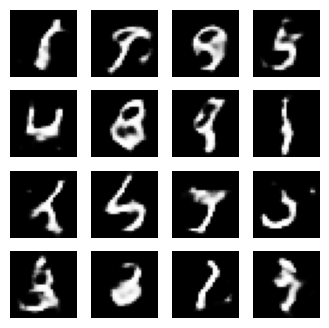

 41%|████      | 41/100 [09:09<12:32, 12.75s/it]

Época 41, Pérdida Generador: 0.9614, Pérdida Discriminador: 1.2081


 42%|████▏     | 42/100 [09:21<11:58, 12.39s/it]

Época 42, Pérdida Generador: 0.9513, Pérdida Discriminador: 1.2309


 43%|████▎     | 43/100 [09:32<11:30, 12.11s/it]

Época 43, Pérdida Generador: 0.9581, Pérdida Discriminador: 1.2194


 44%|████▍     | 44/100 [09:44<11:06, 11.90s/it]

Época 44, Pérdida Generador: 0.9819, Pérdida Discriminador: 1.2105
Época 45, Pérdida Generador: 1.0339, Pérdida Discriminador: 1.1981


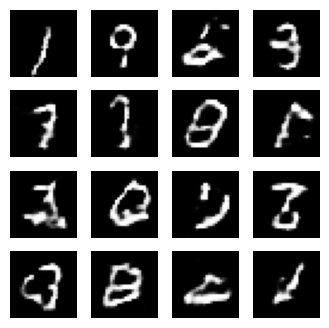

 46%|████▌     | 46/100 [10:06<10:30, 11.67s/it]

Época 46, Pérdida Generador: 1.0075, Pérdida Discriminador: 1.2052


 47%|████▋     | 47/100 [10:18<10:13, 11.57s/it]

Época 47, Pérdida Generador: 1.0018, Pérdida Discriminador: 1.2102


 48%|████▊     | 48/100 [10:38<12:20, 14.24s/it]

Época 48, Pérdida Generador: 1.0056, Pérdida Discriminador: 1.2138


 49%|████▉     | 49/100 [10:50<11:23, 13.39s/it]

Época 49, Pérdida Generador: 0.9730, Pérdida Discriminador: 1.2131
Época 50, Pérdida Generador: 0.9364, Pérdida Discriminador: 1.2295


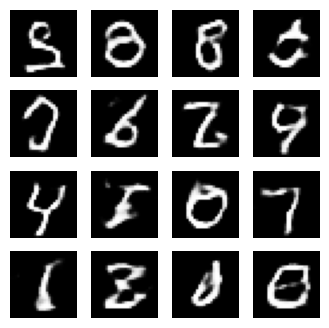

 51%|█████     | 51/100 [11:13<10:12, 12.51s/it]

Época 51, Pérdida Generador: 0.9337, Pérdida Discriminador: 1.2315


 52%|█████▏    | 52/100 [11:25<09:45, 12.20s/it]

Época 52, Pérdida Generador: 0.9834, Pérdida Discriminador: 1.2009


 53%|█████▎    | 53/100 [11:36<09:22, 11.96s/it]

Época 53, Pérdida Generador: 0.9953, Pérdida Discriminador: 1.2180


 54%|█████▍    | 54/100 [11:47<09:02, 11.78s/it]

Época 54, Pérdida Generador: 0.9605, Pérdida Discriminador: 1.2223
Época 55, Pérdida Generador: 0.9466, Pérdida Discriminador: 1.2293


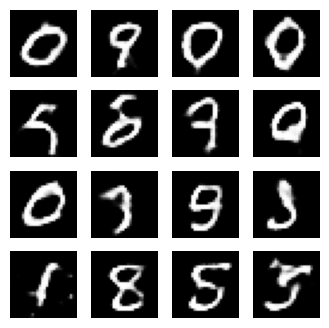

 56%|█████▌    | 56/100 [12:10<08:30, 11.60s/it]

Época 56, Pérdida Generador: 0.9443, Pérdida Discriminador: 1.2218


 57%|█████▋    | 57/100 [12:22<08:16, 11.54s/it]

Época 57, Pérdida Generador: 0.9257, Pérdida Discriminador: 1.2333


 58%|█████▊    | 58/100 [12:33<08:03, 11.50s/it]

Época 58, Pérdida Generador: 0.9555, Pérdida Discriminador: 1.2351


 59%|█████▉    | 59/100 [12:44<07:50, 11.48s/it]

Época 59, Pérdida Generador: 0.9726, Pérdida Discriminador: 1.2217
Época 60, Pérdida Generador: 0.9974, Pérdida Discriminador: 1.2031


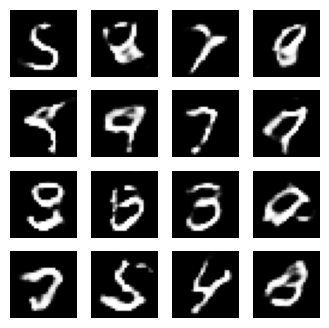

 61%|██████    | 61/100 [13:08<07:31, 11.57s/it]

Época 61, Pérdida Generador: 0.9703, Pérdida Discriminador: 1.2354


 62%|██████▏   | 62/100 [13:19<07:17, 11.52s/it]

Época 62, Pérdida Generador: 0.9694, Pérdida Discriminador: 1.2184


 63%|██████▎   | 63/100 [13:31<07:04, 11.48s/it]

Época 63, Pérdida Generador: 0.9605, Pérdida Discriminador: 1.2280


 64%|██████▍   | 64/100 [13:51<08:30, 14.18s/it]

Época 64, Pérdida Generador: 0.9584, Pérdida Discriminador: 1.2260
Época 65, Pérdida Generador: 0.9559, Pérdida Discriminador: 1.2218


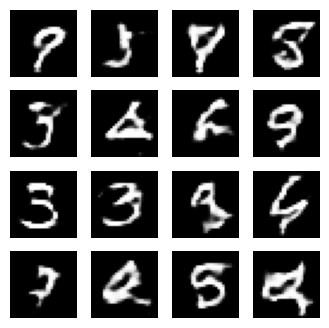

 66%|██████▌   | 66/100 [14:14<07:16, 12.83s/it]

Época 66, Pérdida Generador: 0.9472, Pérdida Discriminador: 1.2209


 67%|██████▋   | 67/100 [14:35<08:19, 15.12s/it]

Época 67, Pérdida Generador: 0.9447, Pérdida Discriminador: 1.2338


 68%|██████▊   | 68/100 [14:46<07:28, 14.03s/it]

Época 68, Pérdida Generador: 0.9546, Pérdida Discriminador: 1.2339


 69%|██████▉   | 69/100 [14:58<06:50, 13.26s/it]

Época 69, Pérdida Generador: 0.9767, Pérdida Discriminador: 1.2187
Época 70, Pérdida Generador: 0.9702, Pérdida Discriminador: 1.2146


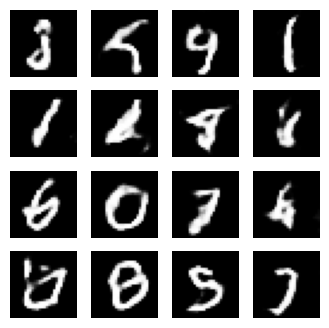

 71%|███████   | 71/100 [15:21<05:59, 12.38s/it]

Época 71, Pérdida Generador: 0.9667, Pérdida Discriminador: 1.2150


 72%|███████▏  | 72/100 [15:32<05:38, 12.09s/it]

Época 72, Pérdida Generador: 0.9560, Pérdida Discriminador: 1.2209


 73%|███████▎  | 73/100 [15:44<05:20, 11.89s/it]

Época 73, Pérdida Generador: 0.9615, Pérdida Discriminador: 1.2150


 74%|███████▍  | 74/100 [15:55<05:05, 11.73s/it]

Época 74, Pérdida Generador: 0.9820, Pérdida Discriminador: 1.2059
Época 75, Pérdida Generador: 0.9470, Pérdida Discriminador: 1.2319


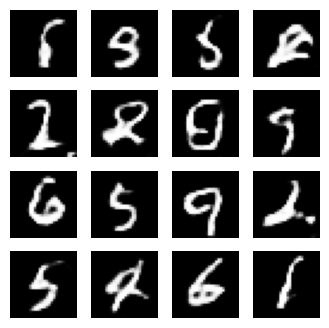

 76%|███████▌  | 76/100 [16:18<04:38, 11.61s/it]

Época 76, Pérdida Generador: 0.9365, Pérdida Discriminador: 1.2333


 77%|███████▋  | 77/100 [16:29<04:25, 11.54s/it]

Época 77, Pérdida Generador: 0.9290, Pérdida Discriminador: 1.2355


 78%|███████▊  | 78/100 [16:41<04:12, 11.50s/it]

Época 78, Pérdida Generador: 0.9248, Pérdida Discriminador: 1.2340


 79%|███████▉  | 79/100 [16:52<04:00, 11.47s/it]

Época 79, Pérdida Generador: 0.9725, Pérdida Discriminador: 1.2132
Época 80, Pérdida Generador: 1.0410, Pérdida Discriminador: 1.2125


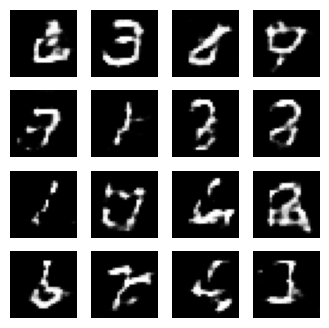

 81%|████████  | 81/100 [17:24<04:29, 14.20s/it]

Época 81, Pérdida Generador: 1.0251, Pérdida Discriminador: 1.1996


 82%|████████▏ | 82/100 [17:36<04:00, 13.35s/it]

Época 82, Pérdida Generador: 0.9604, Pérdida Discriminador: 1.2264


 83%|████████▎ | 83/100 [17:47<03:37, 12.79s/it]

Época 83, Pérdida Generador: 0.9474, Pérdida Discriminador: 1.2311


 84%|████████▍ | 84/100 [17:59<03:18, 12.42s/it]

Época 84, Pérdida Generador: 0.9290, Pérdida Discriminador: 1.2374
Época 85, Pérdida Generador: 0.9173, Pérdida Discriminador: 1.2399


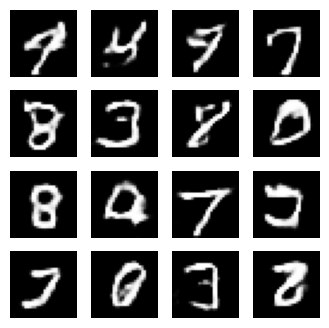

 86%|████████▌ | 86/100 [18:22<02:47, 11.97s/it]

Época 86, Pérdida Generador: 0.9229, Pérdida Discriminador: 1.2354


 87%|████████▋ | 87/100 [18:33<02:33, 11.79s/it]

Época 87, Pérdida Generador: 0.9451, Pérdida Discriminador: 1.2337


 88%|████████▊ | 88/100 [18:44<02:19, 11.66s/it]

Época 88, Pérdida Generador: 0.9924, Pérdida Discriminador: 1.2280


 89%|████████▉ | 89/100 [18:56<02:07, 11.57s/it]

Época 89, Pérdida Generador: 1.0030, Pérdida Discriminador: 1.2119
Época 90, Pérdida Generador: 0.9670, Pérdida Discriminador: 1.2227


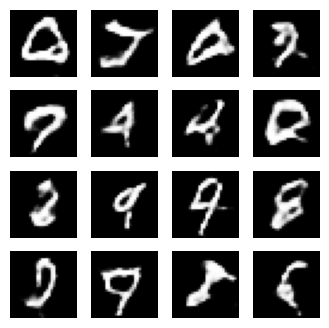

 91%|█████████ | 91/100 [19:19<01:44, 11.60s/it]

Época 91, Pérdida Generador: 0.9539, Pérdida Discriminador: 1.2228


 92%|█████████▏| 92/100 [19:31<01:32, 11.55s/it]

Época 92, Pérdida Generador: 0.9420, Pérdida Discriminador: 1.2367


 93%|█████████▎| 93/100 [19:42<01:20, 11.51s/it]

Época 93, Pérdida Generador: 0.9386, Pérdida Discriminador: 1.2362


 94%|█████████▍| 94/100 [19:53<01:08, 11.49s/it]

Época 94, Pérdida Generador: 0.9662, Pérdida Discriminador: 1.2249
Época 95, Pérdida Generador: 0.9685, Pérdida Discriminador: 1.2224


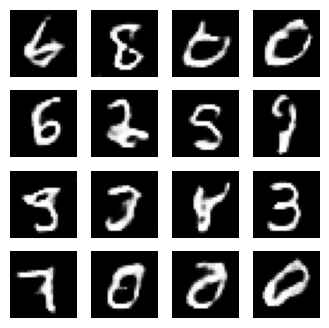

 96%|█████████▌| 96/100 [20:16<00:45, 11.49s/it]

Época 96, Pérdida Generador: 0.9621, Pérdida Discriminador: 1.2319


 97%|█████████▋| 97/100 [20:28<00:34, 11.46s/it]

Época 97, Pérdida Generador: 0.9664, Pérdida Discriminador: 1.2291


 98%|█████████▊| 98/100 [20:39<00:22, 11.44s/it]

Época 98, Pérdida Generador: 0.9520, Pérdida Discriminador: 1.2372


 99%|█████████▉| 99/100 [20:51<00:11, 11.42s/it]

Época 99, Pérdida Generador: 0.9452, Pérdida Discriminador: 1.2367
Época 100, Pérdida Generador: 0.9366, Pérdida Discriminador: 1.2360


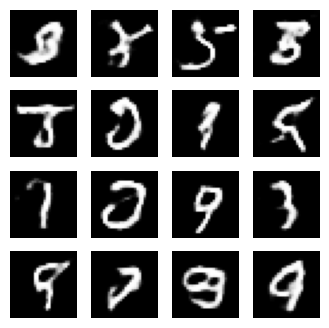

100%|██████████| 100/100 [21:11<00:00, 12.72s/it]

Entrenamiento finalizado.


In [ ]:
@tf.function
def train_step(images, latent_dim):
    noise = tf.random.normal([images.shape[0], latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    # Listas para almacenar las pérdidas por época
    gen_losses = []
    disc_losses = []

    for epoch in tqdm(range(epochs)):
        epoch_gen_loss_avg = tf.metrics.Mean()
        epoch_disc_loss_avg = tf.metrics.Mean()

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch, LATENT_DIM)
            epoch_gen_loss_avg.update_state(g_loss)
            epoch_disc_loss_avg.update_state(d_loss)

        # Almacenar la pérdida promedio de la época
        gen_losses.append(epoch_gen_loss_avg.result().numpy())
        disc_losses.append(epoch_disc_loss_avg.result().numpy())
        print(f'Época {epoch + 1}, Pérdida Generador: {gen_losses[-1]:.4f}, Pérdida Discriminador: {disc_losses[-1]:.4f}')

        if (epoch + 1) % 5 == 0:
            display_images(generator, latent_dim=LATENT_DIM)

    return gen_losses, disc_losses

def display_images(generator, latent_dim):
    num_examples_to_generate = 16
    noise = tf.random.normal([num_examples_to_generate, latent_dim])
    generated_images = generator(noise, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

# Instanciar modelos y comenzar el entrenamiento
generator = build_generator(LATENT_DIM)
discriminator = build_discriminator((28, 28, 1))
print("Comenzando el entrenamiento...")
gen_losses, disc_losses = train(train_dataset, epochs=epochs)
print("Entrenamiento finalizado.")

## Análisis de Resultados

Visualización de las Pérdidas
La visualización de las pérdidas es fundamental para diagnosticar el entrenamiento de una GAN. En el siguiente gráfico, podemos ver cómo la pérdida del generador y del discriminador interactúan a lo largo del tiempo.

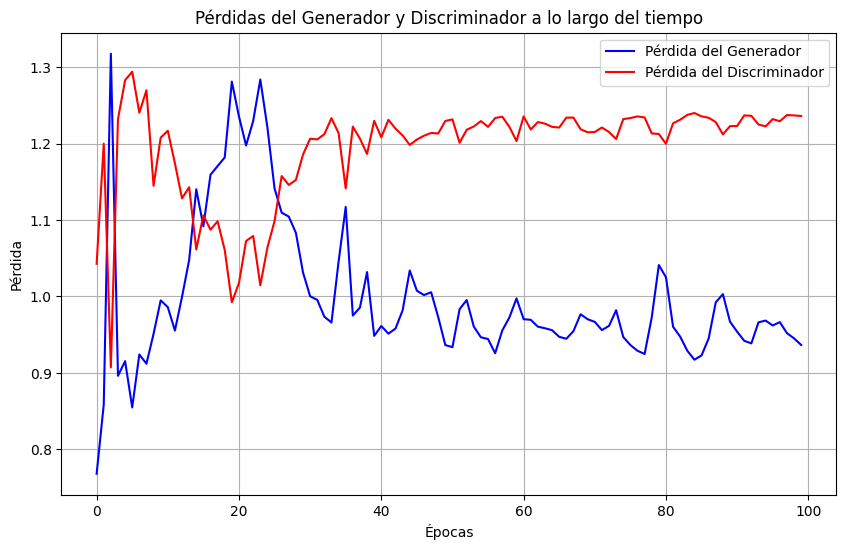

In [ ]:
plot_losses(gen_losses, disc_losses)

## Análisis del Gráfico:

**Comportamiento Fluctuante:** Es normal que las pérdidas de una GAN no disminuyan suavemente. Las fluctuaciones muestran la lucha constante entre el generador y el discriminador. Si una pérdida baja, la otra tiende a subir.

**Equilibrio:** Un entrenamiento exitoso se manifiesta con las pérdidas oscilando alrededor de un valor estable. Esto indica que el sistema ha alcanzado un equilibrio, donde el generador es lo suficientemente bueno para engañar al discriminador en un 50% de las veces, y el discriminador es lo suficientemente bueno para detectar los datos falsos el 50% de las veces.

**Problemas de Entrenamiento:** Si una pérdida se va a cero mientras la otra se dispara, puede ser una señal de colapso del modo ("mode collapse") o que una red ha superado a la otra.

## Generación Final de Imágenes
Finalmente, generamos una cuadrícula de imágenes para ver la calidad de los resultados después de 50/100 épocas de entrenamiento. La visualización de las pérdidas confirma que el sistema se ha mantenido en un equilibrio competitivo, lo que se traduce en la generación de dígitos. Durante entreneamiento pudimos observar como la red mejora durante el tiempo sin embargo, para optener mejores resultados es necesario redes mas complejas y mas tiempo de ejecucion

Imágenes generadas al final del entrenamiento:


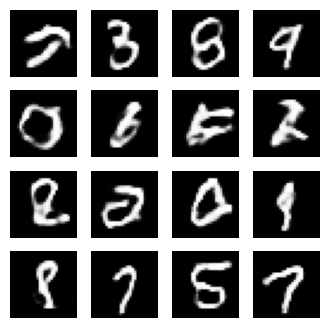

In [ ]:
print("Imágenes generadas al final del entrenamiento:")
display_images(generator, latent_dim=LATENT_DIM)